In [ ]:
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model

# Data Loader

In [ ]:
from google.colab import drive
#drive.mount('/gdrive')
 
drive.mount('/gdrive')  
%cd /
%cd 'gdrive/MyDrive/IVF/FETAL/DAY 3'
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/
/gdrive/MyDrive/IVF/FETAL/DAY 3
good/  poor/


In [ ]:
BATCH_SIZE = 4
IMG_SIZE = 299
NUM_CLASSES = 2
train_dir = 'D3_Transfer'
positive_dir = 'Do_Not_Look_Inside/p'
negative_dir = 'Do_Not_Look_Inside/n'
validation_dir = 'stork_set'

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255.,
                                   #rotation_range = 360,
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2,
                                   #shear_range = 0.2,
                                   #zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split=0.2
                                   )



casual_generator = datagen.flow_from_directory(train_dir,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical', 
                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                  subset='training')

positive_generator = datagen.flow_from_directory(positive_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical', 
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    subset='training')

negative_generator = datagen.flow_from_directory(negative_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical', 
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    subset='training')

validation_generator = datagen.flow_from_directory(train_dir,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical', 
                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                  subset='validation')

In [ ]:
def generator_three_img():

    while True:
        X1i = casual_generator.next()
        X2i = positive_generator.next()
        X3i = negative_generator.next()

        Xp1 = positive_generator.next()
        Xn1 = negative_generator.next()
        Xp2 = positive_generator.next()
        Xn2 = negative_generator.next()
        Xp3 = positive_generator.next()
        Xn3 = negative_generator.next()

        y = X1i[1]
        
        if (Xp1[0].shape[0]!=BATCH_SIZE) or (Xn1[0].shape[0]!=BATCH_SIZE):
          #print('Error:',X1i[0].shape[0],X2i[0].shape[0],X3i[0].shape[0])
          continue

        if (Xp2[0].shape[0]!=BATCH_SIZE) or (Xn2[0].shape[0]!=BATCH_SIZE):
          #print('Error:',X1i[0].shape[0],X2i[0].shape[0],X3i[0].shape[0])
          continue

        if (Xp3[0].shape[0]!=BATCH_SIZE) or (Xn3[0].shape[0]!=BATCH_SIZE):
          #print('Error:',X1i[0].shape[0],X2i[0].shape[0],X3i[0].shape[0])
          continue

        if (X1i[0].shape[0]!=BATCH_SIZE) or (X2i[0].shape[0]!=BATCH_SIZE) or (X3i[0].shape[0]!=BATCH_SIZE):
          #print('Error:',X1i[0].shape[0],X2i[0].shape[0],X3i[0].shape[0])
          continue

        yield [X1i[0], X2i[0], X3i[0], Xp1[0], Xn1[0], Xp2[0], Xn2[0], Xp3[0], Xn3[0]], y


# Finally create generator
gen_flow = generator_three_img()

(4, 299, 299, 3) (4, 299, 299, 3) (4, 299, 299, 3)
Example of the augmented dataset


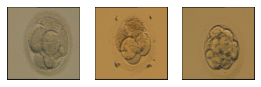

"\nprint('Example of the non-augmented dataset')  \nx,y = validation_generator.next()\nfor i in range(1):\n    ax = plt.subplot(2, 4, i + 1)\n    plt.axis('off')\n    image = x[i]\n    plt.imshow(image)\nplt.show()\n"

In [ ]:

x,y = next(gen_flow)
print(x[1].shape,x[0].shape,x[2].shape)
print('Example of the augmented dataset')
for i in range(3):
    ax = plt.subplot(2, 4, i + 1)
    plt.axis('off')
    image = x[i][0]
    plt.imshow(image)
plt.show()

'''
print('Example of the non-augmented dataset')  
x,y = validation_generator.next()
for i in range(1):
    ax = plt.subplot(2, 4, i + 1)
    plt.axis('off')
    image = x[i]
    plt.imshow(image)
plt.show()
'''

#Model Definitions

In [ ]:
import numpy as np

# Sys
import warnings
# Keras Core
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers import Input, Dropout, Dense, Flatten, Activation
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras import regularizers
from keras import initializers
from keras.models import Model
# Backend
from keras import backend as K
# Utils
from keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_custom_objects



def preprocess_input(x):
    x = np.divide(x, 255.0)
    x = np.subtract(x, 0.5)
    x = np.multiply(x, 2.0)
    return x


def swish(x):
  alpha = 1.
  beta  = 1.
  return (K.sigmoid(beta * x) * alpha *x)

get_custom_objects().update({'swish': swish})


def mish(x):
  return (K.tanh( K.softplus( x ) ) * x)

get_custom_objects().update({'mish': mish})

class MCDropout(Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

'''
def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x
'''

w_scale = 1


def conv2d_bn(x, nb_filter, num_row, num_col, padding='same', strides=(1, 1), use_bias=False):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D((nb_filter*w_scale)//1, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      #kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.00001, l2=0.001),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    #x = BatchNormalization(axis=channel_axis, momentum=0.9, scale=False)(x)
    x = Activation('mish')(x)
    #x = MCDropout(0.3)(x)
    return x


def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)

    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)

    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 1, 1)

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)

    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 256, 1, 1)

    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)

    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)

    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)

    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)

    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)

    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)

    return net


def inception_v4(num_classes, dropout_keep_prob, weights, include_top):
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 299, 299))
    else:
        inputs = Input((299, 299, 3))
    x = inception_v4_base(inputs)

    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        #x = MCDropout(dropout_keep_prob)(x)
        #x = Flatten()(x)
        # 1536
        '''
        y = Dense(units=(1536*w_scale)//1, activation=None)(x)
        y = Activation('mish')(y)
        y = MCDropout(dropout_keep_prob)(y)
        x = layers.Add()([x,y])
        '''

    model = Model(inputs, x, name='inception_v4')
    return model


def create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=True):
  model = inception_v4(num_classes, dropout_prob, weights, include_top)
  #model.summary()
  return model


class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, casual, positive, negative, positive1, negative1, positive2, negative2, positive3, negative3):

        
        positive_distance = tf.reduce_sum(tf.square(casual - positive), -1)
        negative_distance = tf.reduce_sum(tf.square(casual - negative), -1)
        positive_distance = layers.Reshape((1,1))(positive_distance)
        negative_distance = layers.Reshape((1,1))(negative_distance)

        positive_distance1 = tf.reduce_sum(tf.square(casual - positive1), -1)
        negative_distance1 = tf.reduce_sum(tf.square(casual - negative1), -1)
        positive_distance1 = layers.Reshape((1,1))(positive_distance1)
        negative_distance1 = layers.Reshape((1,1))(negative_distance1)

        positive_distance2 = tf.reduce_sum(tf.square(casual - positive2), -1)
        negative_distance2 = tf.reduce_sum(tf.square(casual - negative2), -1)
        positive_distance2 = layers.Reshape((1,1))(positive_distance2)
        negative_distance2 = layers.Reshape((1,1))(negative_distance2)

        positive_distance3 = tf.reduce_sum(tf.square(casual - positive3), -1)
        negative_distance3 = tf.reduce_sum(tf.square(casual - negative3), -1)
        positive_distance3 = layers.Reshape((1,1))(positive_distance3)
        negative_distance3 = layers.Reshape((1,1))(negative_distance3)
        
        positive_euclid = positive_distance + positive_distance1 + positive_distance2 + positive_distance3
        negative_euclid = negative_distance + negative_distance1 + negative_distance2 + negative_distance3

        positive_distance = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(casual, 0), tf.nn.l2_normalize(positive, 0)),axis=-1)
        negative_distance = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(casual, 0), tf.nn.l2_normalize(negative, 0)),axis=-1)
        positive_distance = layers.Reshape((1,1))(positive_distance)
        negative_distance = layers.Reshape((1,1))(negative_distance)

        positive_distance1 = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(casual, 0), tf.nn.l2_normalize(positive1, 0)),axis=-1)
        negative_distance1 = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(casual, 0), tf.nn.l2_normalize(negative1, 0)),axis=-1)
        positive_distance1 = layers.Reshape((1,1))(positive_distance1)
        negative_distance1 = layers.Reshape((1,1))(negative_distance1)

        positive_distance2 = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(casual, 0), tf.nn.l2_normalize(positive2, 0)),axis=-1)
        negative_distance2 = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(casual, 0), tf.nn.l2_normalize(negative2, 0)),axis=-1)
        positive_distance2 = layers.Reshape((1,1))(positive_distance2)
        negative_distance2 = layers.Reshape((1,1))(negative_distance2)

        positive_distance3 = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(casual, 0), tf.nn.l2_normalize(positive3, 0)),axis=-1)
        negative_distance3 = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(casual, 0), tf.nn.l2_normalize(negative3, 0)),axis=-1)
        positive_distance3 = layers.Reshape((1,1))(positive_distance3)
        negative_distance3 = layers.Reshape((1,1))(negative_distance3)


        positive_cosine = positive_distance + positive_distance1 + positive_distance2 + positive_distance3
        negative_cosine = negative_distance + negative_distance1 + negative_distance2 + negative_distance3
        
        positive_distance = positive_euclid + positive_cosine
        negative_distance = negative_euclid + negative_cosine

        return  (positive_distance/6, negative_distance/6)

In [ ]:
casual   = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="casual")
positive = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="positive")
negative = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="negative")


positive1 = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="positive1")
negative1 = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="negative1")
positive2 = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="positive2")
negative2 = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="negative2")
positive3 = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="positive3")
negative3 = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="negative3")

encoder = create_model(num_classes = 2, dropout_prob = 0.5, weights=None, include_top = True)
#encoder = tf.keras.applications.Xception(include_top=False,weights="imagenet")

encoded_casual = encoder(casual)
encoded_positive = encoder(positive)
encoded_negative = encoder(negative)


encoded_positive1 = encoder(positive1)
encoded_negative1 = encoder(negative2)
encoded_positive2 = encoder(positive1)
encoded_negative2 = encoder(negative2)
encoded_positive3 = encoder(positive3)
encoded_negative3 = encoder(negative3)

#encoded_casual   = BatchNormalization(momentum=0.99)(encoded_casual)
#encoded_positive = BatchNormalization(momentum=0.99)(encoded_positive)
#encoded_negative = BatchNormalization(momentum=0.99)(encoded_negative)

#print(encoded_casual)
#print(encoded_positive)

p,n = DistanceLayer()(
    encoded_casual,
    encoded_positive,
    encoded_negative,

    encoded_positive1,
    encoded_negative1,
    encoded_positive2,
    encoded_negative2,
    encoded_positive3,
    encoded_negative3
)


out = concatenate([p,n], axis=-1)



#print(out)

model = Model(inputs = [casual,positive,negative,positive1,negative1,positive2,negative2,positive3,negative3], outputs = out, name='fuck_IVF')

In [ ]:
model.summary()

#Contrastive Model Stack and Training

In [ ]:
casual0   = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="casual")

encoded_casual = encoder(casual0)
x = Flatten()(encoded_casual)
x = Dropout(0.5)(x)
x = Dense(4096)(x)
x = Dropout(0.3)(x)
out0 = Dense(NUM_CLASSES, activation="softmax")(x)

classifier = Model(inputs = casual0, outputs = out0, name='fuck_IVF_with_class')

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss = 'categorical_crossentropy'
#loss = tf.keras.losses.CategoricalHinge()
metrics = ['accuracy']
classifier.compile(
    optimizer=optimizer, loss=loss, metrics=metrics#["accuracy"]
)



model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint/modelv6.0',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,patience=5, min_lr=0.000001),
    #model_checkpoint_callback,
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 524  # @param {type: "slider", min:1, max:1000}
hist = classifier.fit(casual_generator,
                 validation_data = validation_generator,
                 epochs=epochs,
                 #steps_per_epoch = 150//4,
                 callbacks=my_callbacks,
                 verbose=1)

In [ ]:
def loss_fn(margin=1):
  def triplet_loss(y_true, distances):  
    #print("CHECK:",y_true,distances)
    #print(tf.shape(distances))
    #print(tf.shape(y_true))
    #y_true = tf.squeeze(y_true,[1])
    phi = tf.constant([[1.0, -1.0]])
    y_true = tf.reshape(y_true,[-1,2])
    #print(tf.shape(y_true))
    dist_loss  = tf.matmul(distances,tf.transpose(phi))
    label_loss = tf.matmul(y_true,tf.transpose(phi))
    #print('dist loss: ',dist_loss)
    #print('label loss: ',label_loss)
    loss = dist_loss * label_loss
    #print('loss: ',loss)
    #margin = tf.reduce_max(y_true)
    print(y_true,margin)
    loss = tf.maximum(loss + margin, 0.0)
    #print('loss: ',loss)
    return loss
  return triplet_loss

def dist_accuracy(y_true, y_pred):
    #comparison = tf.equal( y_pred,  tf.reduce_max(y_pred)  )
    #y_pred = tf.where( comparison, 1.0,0.0)
    comparison, _ = tf.nn.top_k(y_pred, 1)
    y_pred = tf.cast(tf.greater_equal(y_pred, comparison), tf.float32)
    y_true_ex = tf.expand_dims(y_true,1)
     #print(y_pred,y_true_ex)
    del_y = y_true_ex - y_pred
    y = tf.reduce_max( del_y,axis=2)

    '''
    print("\n*************\n")
    print(tf.shape(comparison))
    print(tf.shape(y_pred))
    print(tf.shape(y_true))
    #print(tf.shape(y_true_ex))
    print(tf.shape(del_y))
    print(tf.shape(y))
    print(tf.shape(tf.reduce_mean(y)))
    print("\n*************")

    
    print("\n\n*************\n")
    print(comparison)
    print(y_pred)
    print(y_true_ex)
    print(y_true)
    print(del_y)
    print(y)
    print(tf.reduce_mean(y))
    print("*************")
    '''
    
    return tf.reduce_mean(y) 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)



#loss = 'categorical_crossentropy'
#loss = tf.keras.losses.CategoricalHinge()


metrics = [
           dist_accuracy
           #'accuracy',
           #tf.keras.metrics.Recall(),
           #tf.keras.metrics.Precision()
           ]


model.compile(
    optimizer=optimizer, loss=loss_fn(margin=0), metrics=metrics#["accuracy"]
)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint/modelv6.0',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,patience=3, min_lr=0.00000001),
    #model_checkpoint_callback,
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 300  # @param {type: "slider", min:1, max:1000}
hist = model.fit(gen_flow,
                 #validation_data = validation_generator,
                 epochs=epochs,
                 steps_per_epoch = 150//BATCH_SIZE,
                 callbacks=my_callbacks,
                 verbose=1)

In [ ]:
check = 4
x,y = next(gen_flow)
p = model(x, training=False)   

lossy = loss_fn(margin=0)
l = lossy(p,y)
print('=>',dist_accuracy(y,p))
#print('=>',l)
#print('=>',(p,y))

p = p.numpy()

for i in range(check):
  print('=====================\n',p[i],y[i],l[i],'\n=====================')

In [ ]:
encoder.trainable=False

casual   = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="casual")

encoded_casual = encoder(casual)
x = Flatten()(encoded_casual)
x = Dropout(0.5)(x)
x = Dense(4096)(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation="softmax")(x)

classifier = Model(inputs = casual, outputs = out, name='fuc_IVF_with_class')

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss = 'categorical_crossentropy'
#loss = tf.keras.losses.CategoricalHinge()
metrics = ['accuracy']
classifier.compile(
    optimizer=optimizer, loss=loss, metrics=metrics#["accuracy"]
)



model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint/modelv6.1',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,patience=5, min_lr=0.00001),
    model_checkpoint_callback,
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 300  # @param {type: "slider", min:1, max:1000}
hist = classifier.fit(casual_generator,
                 validation_data = validation_generator,
                 epochs=epochs,
                 #steps_per_epoch = 150//4,
                 callbacks=my_callbacks,
                 verbose=1)

Epoch 1/300
31/31 [==============================] - 42s 1s/step - loss: 11064137.0000 - accuracy: 0.4793 - val_loss: 3241167.7500 - val_accuracy: 0.3667 - lr: 0.0100
Epoch 2/300
31/31 [==============================] - 2s 62ms/step - loss: 11089556.0000 - accuracy: 0.4959 - val_loss: 1125791.5000 - val_accuracy: 0.3667 - lr: 0.0100
Epoch 3/300
31/31 [==============================] - 2s 62ms/step - loss: 9602218.0000 - accuracy: 0.5372 - val_loss: 15430630.0000 - val_accuracy: 0.3667 - lr: 0.0100
Epoch 4/300
31/31 [==============================] - 3s 89ms/step - loss: 10204979.0000 - accuracy: 0.4793 - val_loss: 4787296.5000 - val_accuracy: 0.6333 - lr: 0.0100
Epoch 5/300
31/31 [==============================] - 2s 61ms/step - loss: 12656036.0000 - accuracy: 0.5207 - val_loss: 3007614.7500 - val_accuracy: 0.3667 - lr: 0.0100
Epoch 6/300
31/31 [==============================] - 2s 61ms/step - loss: 10826020.0000 - accuracy: 0.3967 - val_loss: 5248924.5000 - val_accuracy: 0.3667 - lr: 

In [ ]:
classifier.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
#loss = tf.keras.losses.CategoricalHinge()
metrics = ['accuracy']
classifier.compile(
    optimizer=optimizer, loss=loss, metrics=metrics#["accuracy"]
)



model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint/modelv6.1',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,patience=5, min_lr=0.00001),
    model_checkpoint_callback,
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 300  # @param {type: "slider", min:1, max:1000}
hist = classifier.fit(casual_generator,
                 validation_data = validation_generator,
                 epochs=epochs,
                 #steps_per_epoch = 150//4,
                 callbacks=my_callbacks,
                 verbose=1)

Epoch 1/300
31/31 [==============================] - 18s 270ms/step - loss: 2356.6985 - accuracy: 0.5950 - val_loss: 1.3947 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 2/300
31/31 [==============================] - 4s 127ms/step - loss: 5.9686 - accuracy: 0.5455 - val_loss: 1.2690 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 3/300
31/31 [==============================] - 4s 126ms/step - loss: 1.9170 - accuracy: 0.4628 - val_loss: 0.6909 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 4/300
31/31 [==============================] - 4s 130ms/step - loss: 1.1773 - accuracy: 0.5702 - val_loss: 0.7110 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 5/300
31/31 [==============================] - 4s 130ms/step - loss: 0.8127 - accuracy: 0.5537 - val_loss: 0.6667 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 6/300
31/31 [==============================] - 4s 127ms/step - loss: 0.8795 - accuracy: 0.4959 - val_loss: 0.6555 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 7/300
31/31 [=================

In [ ]:
print(model(x, training=False).numpy())

print(model(x, training=True).numpy())
print(y)